In [1]:
#! /usr/bin/python

In [2]:
import cv2
import numpy as np
from scipy import ndimage

from matplotlib import pyplot as plt
from scipy import signal

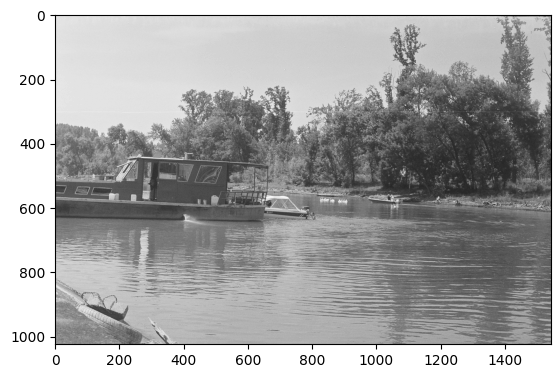

In [21]:
img = cv2.imread("res/img/034.JPG")
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.figure()
plt.imshow(img, cmap="gray")
plt.show()

In [22]:
def ee(LH: np.array, HL: np.array, p = 2):
    return np.sqrt(LH**p + HL**p)**(1/p)

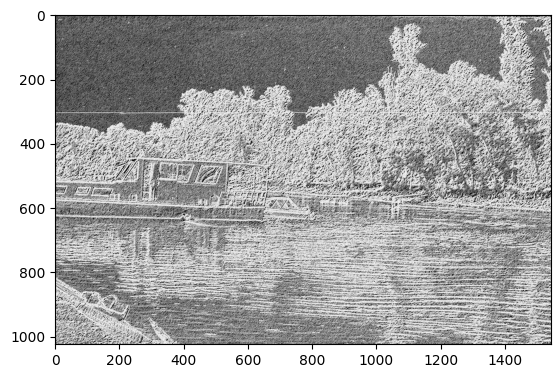

In [23]:
# Edge detection 1
h = 0.125 * np.array([-1, 2, 6, 2, -1],     dtype=np.float32)
g1 = 0.5 * np.array([1, 0, -1],            dtype=np.float32)
g2 = 0.5 * np.array([1, 0, 0, 0, -1],      dtype=np.float32)
g3 = 0.5 * np.array([1, 0, 0, 0, 0, 0 -1], dtype=np.float32)

f1 = np.matrix(np.convolve(h, g1))
imgf1h = cv2.filter2D(img, -1, f1)
imgf1v = cv2.filter2D(img, -1, f1.T)
ee1 = ee(imgf1h, imgf1v)

f2 = np.matrix(np.convolve(h, g2))
imgf2h = cv2.filter2D(img, -1, f2)
imgf2v = cv2.filter2D(img, -1, f2.T)
ee2 = ee(imgf2h, imgf2v)

f3 = np.matrix(np.convolve(h, g3))
imgf3h = cv2.filter2D(img, -1, f3)
imgf3v = cv2.filter2D(img, -1, f3.T)
ee3 = ee(imgf3h, imgf3v)

energy_map = np.maximum(np.maximum(ee1, ee2), ee3)

plt.figure()
plt.imshow(energy_map, cmap="gray")
plt.show()



In [24]:
# Tresholding

img_thresh = np.floor(img*0.125)
img_thresh = np.array(img_thresh, dtype=np.uint8)

thresholds1 = np.full(32, 3, dtype=np.float32)
w = 10E-4
c = 2.5

for x in range(10):
    for value in range(32):
        mask = np.zeros(img.shape, dtype=np.uint8)
        mask[img_thresh==value] = 1
        thresholds1[value] = (1-w) * thresholds1[value] + w*c * np.mean(energy_map[mask==1])

thresholds1 = np.nan_to_num(thresholds1, nan=3)

thresholds1

array([2.9951677, 3.0020952, 3.0200076, 3.0303612, 3.025549 , 3.02166  ,
       3.0265212, 3.0311873, 3.0332785, 3.0333261, 3.0339098, 3.0355139,
       3.0372636, 3.038042 , 3.0380898, 3.0392568, 3.040666 , 3.04193  ,
       3.041979 , 3.0407147, 3.0373123, 3.0330834, 3.0310411, 3.028417 ,
       3.0238466, 3.019083 , 3.0155842, 3.0105772, 3.009532 , 3.0269098,
       3.0382354, 3.0397427], dtype=float32)

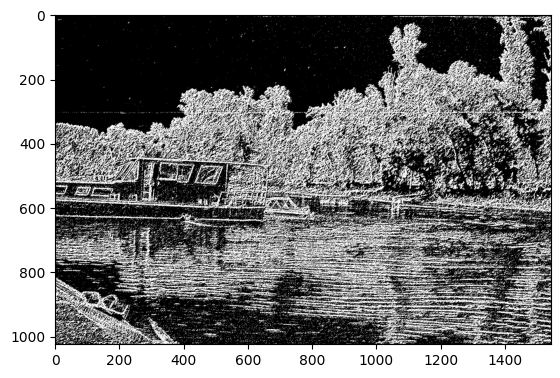

In [25]:
energy_map1 = energy_map.copy()
for val in range(32):
    energy_map1[img_thresh==val] = (energy_map1[img_thresh==val] > thresholds1[val])

plt.figure()
plt.imshow(energy_map1, cmap="gray")
plt.show()

In [26]:
img_thresh = np.floor(img*0.125)
img_thresh = np.array(img_thresh, dtype=np.uint8)

thresholds2 = np.full(32, 0, dtype=np.float32)
w = 10E-4
c = 2.5

for line in range(img.shape[0]):
    for row in range(img.shape[1]):
        level = img_thresh[line][row]
        thresholds2[level] = (1-w) * thresholds2[level] + w * c * energy_map[line][row] 

thresholds2

array([0.37361482, 0.3191535 , 0.34858158, 1.4939876 , 5.0063577 ,
       5.5028954 , 6.0914664 , 6.164812  , 6.207032  , 6.6056347 ,
       6.8475623 , 6.924121  , 6.834135  , 6.772763  , 6.7947764 ,
       6.685295  , 6.631199  , 6.518663  , 6.298327  , 5.725007  ,
       5.2236495 , 4.8794765 , 5.044693  , 5.4255953 , 6.1029353 ,
       6.8727407 , 7.0528116 , 7.0632195 , 7.1114964 , 7.017482  ,
       6.4719415 , 5.8451614 ], dtype=float32)

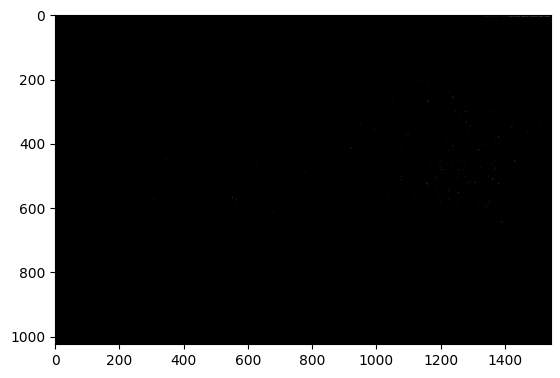

In [27]:
energy_map2 = energy_map.copy()
for val in range(32):
    energy_map2[img_thresh==val] = energy_map2[img_thresh==val] > thresholds2[val]

plt.figure()
plt.imshow(energy_map2, cmap="gray")
plt.show()

In [28]:
def remove_isolated_px(img):
    image = img.copy()
    image_i = cv2.bitwise_not(image)
    
    kernel1 = np.array([[0, 0, 0],
                        [0, 1, 0],
                        [0, 0, 0]], np.uint8)
    kernel2 = np.array([[1, 1, 1],
                        [1, 0, 1],
                        [1, 1, 1]], np.uint8)


    hitormiss1 = cv2.morphologyEx(image, cv2.MORPH_ERODE, kernel1)
    hitormiss2 = cv2.morphologyEx(image_i, cv2.MORPH_ERODE, kernel2)
    hitormiss = cv2.bitwise_and(hitormiss1, hitormiss2)

    hitormiss_i = cv2.bitwise_not(hitormiss)
    return cv2.bitwise_and(image, image, mask=hitormiss_i) 

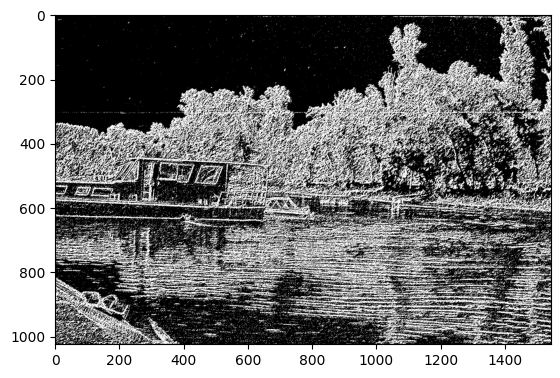

In [29]:
cleaned1 = remove_isolated_px(np.array(energy_map1, dtype=np.uint8))

plt.figure()
plt.imshow(cleaned1, cmap="gray")
plt.show()

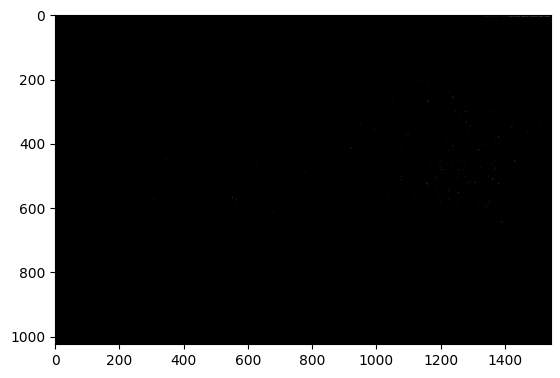

In [30]:
cleaned2 = remove_isolated_px(np.array(energy_map2, dtype=np.uint8))

plt.figure()
plt.imshow(cleaned2, cmap="gray")
plt.show()

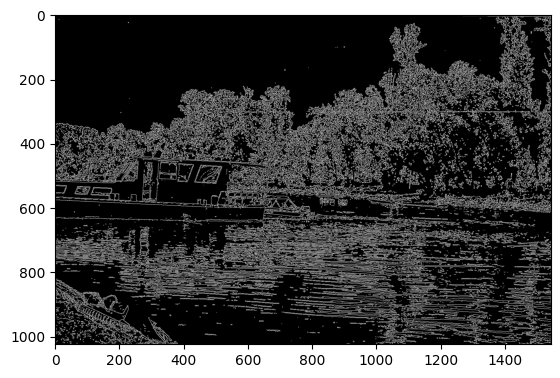

In [31]:
edges = cv2.Canny(img, 100, 150)
edges = remove_isolated_px(np.array(edges, dtype=np.uint8))

plt.figure()
plt.imshow(edges, cmap="gray")
plt.show()

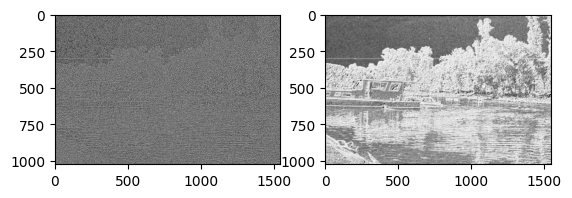

In [32]:
# Fine textures
# TODO

fine_energy = energy_map.copy()
median = cv2.medianBlur(np.array(fine_energy, dtype=np.float32), 5)

fine_energy = fine_energy > median

plt.figure()
plt.subplot(1,2,1)
plt.imshow(fine_energy, cmap="gray")
plt.subplot(1,2,2)
plt.imshow(median, cmap="gray")
plt.show()

In [33]:
def ac_img_along_vec(img, vector: tuple, mean = None):
    if mean is None:
        mean = np.mean(img)
    shifted_img = np.roll(img, vector, (0,1))
    
    # I'm not sure whether this is neccessary
    #if vector.first > 0:
    #    shifted_img[:, :vector.first] = 0
    #elif vector.first < 0:
    #    shifted_img[:, vector.first:] = 0

    #if vector.second > 0:
    #    shifted_img[:vector.second, :] = 0
    #elif vector.second < 0:
    #    shifted_img[vector.second:, :] = 0

    return (img - mean) * (shifted_img - mean)

    

In [34]:
texture_directions = [(1,0), (2,1), (1,1), (1,2), (0,1), (-1,2), (-1,1), (-2,1)]

textures = [ac_img_along_vec(np.array(fine_energy, dtype=np.float32), vec) for vec in texture_directions]

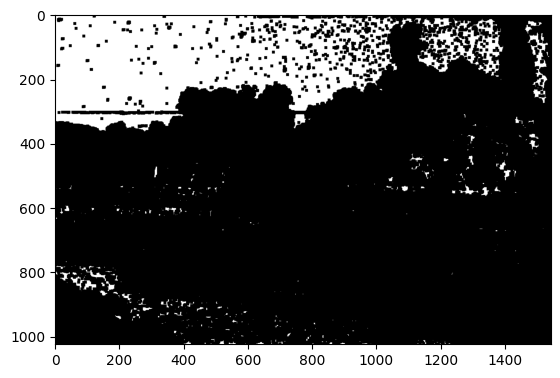

In [35]:
dilation_kernel = np.ones((9,9), dtype=np.uint8)
final_mask = cv2.dilate(cleaned1, dilation_kernel, iterations=1)
final_mask = cv2.bitwise_not(final_mask)
final_mask[final_mask < 255] = 0

plt.figure()
plt.imshow(final_mask, cmap="gray")
plt.show()

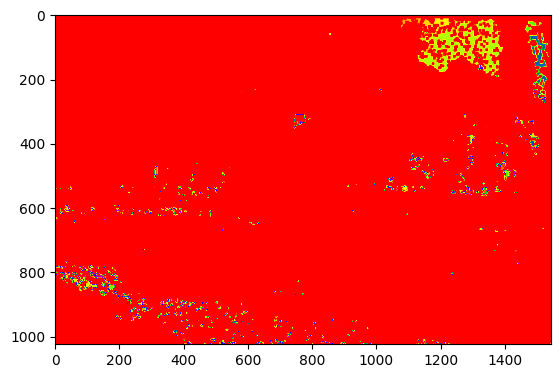

In [36]:
connectivity_map = np.ones((3,3), dtype=np.uint8)
areas, num_features = ndimage.label(final_mask, connectivity_map)

vals, counts = np.unique(areas, return_counts=True)
threshold = max(np.median(counts), 300)
grain_area_indices = []
for val, cnt in zip(vals[1:], counts[1:]):
    if cnt > threshold:
        grain_area_indices.append(val)

plt.figure()
plt.imshow(areas, cmap="prism")
plt.show()

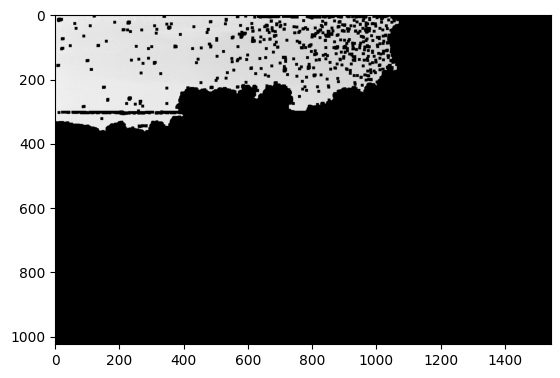

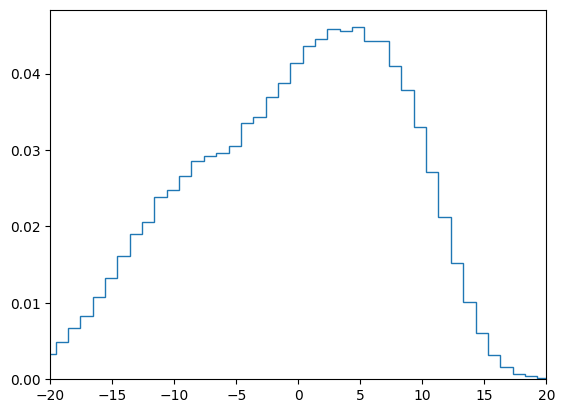

184.0 216.81358 8.3166685


In [37]:
# GRAIN ANALYSIS

id = grain_area_indices[0]

first_area = img.copy()
first_area = np.array(img, dtype=np.float32)
first_area[areas!=id] = -1

noise_min = np.min(first_area[areas==id])
noise_mean = np.mean(first_area[areas==id])
noise_std  = np.std(first_area[areas==id])

plt.figure()
plt.imshow(first_area, cmap="gray")
plt.show()

hist, edges = np.histogram(first_area[areas==id], bins=256, range=(0,255))
hist = hist/np.sum(hist)
edges = edges-noise_mean
plt.figure()
plt.stairs(hist, edges)
plt.xlim([-20, 20])
plt.show()

print(noise_min, noise_mean, noise_std)

In [20]:
a = np.array([[1, 1],
              [2, 2]], dtype=np.float32)
b = np.array([[1, 1],
              [2, 3]], dtype=np.float32)

a-1

array([[0., 0.],
       [1., 1.]], dtype=float32)